# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
pth2 = 'real_estate_data.csv'
pth1 = '/datasets/real_estate_data.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, sep='\t')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, sep='\t')
else:
    print('Something is wrong')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

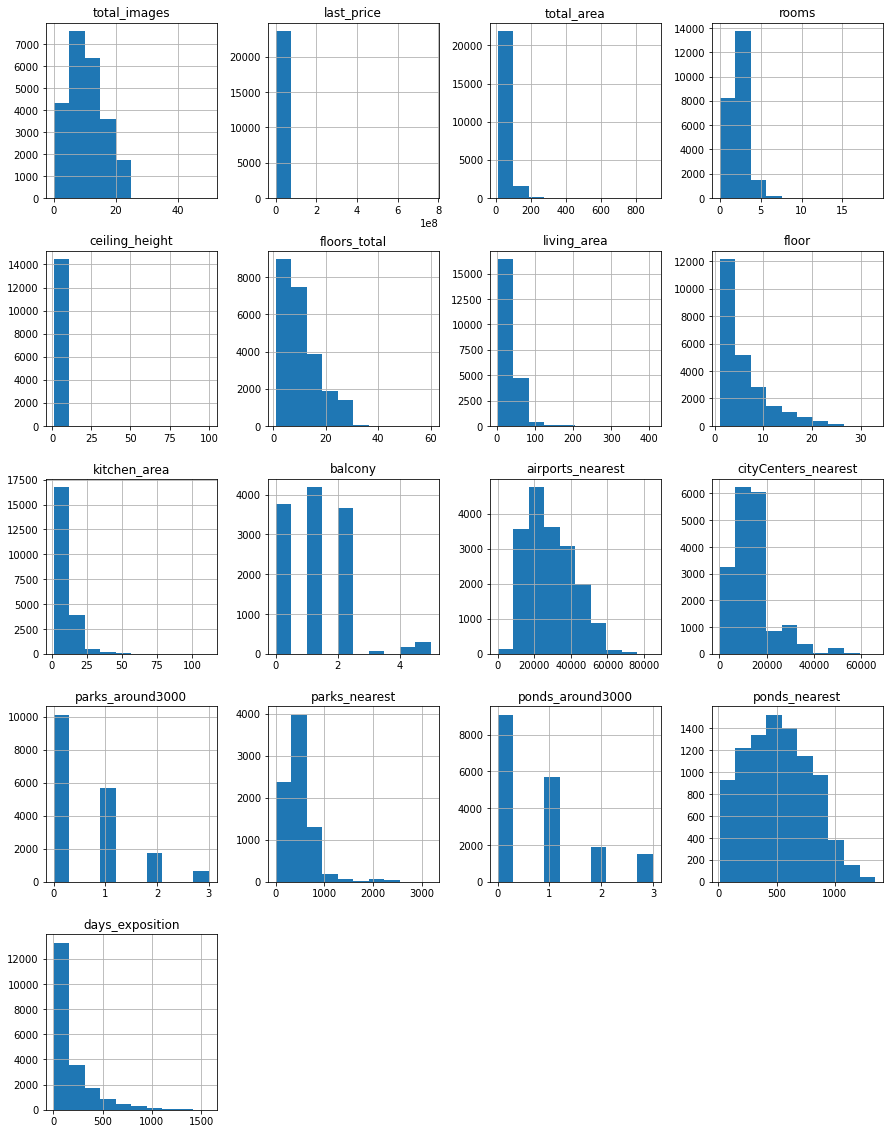

In [3]:
display(data.head())
data.info()
data.hist(figsize=(15, 20));

### Предобработка данных

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Больше всего пропусков в колонке "is_apartment". Апартаменты по сути те же квартиры, но с доп сервисом для жильцов, как гостиничный номер, только с покупкой помещения
Возможно данных нет, потому что они False?
Известно, что часть данных указана пользователем, а часть - картографическая, то есть рассчитана на основе местоположения. Пропуски есть и в тех и в других. Есть вероятность, что картографические данные не указаны, потому что не было точного адреса

Например, если пользователь не указал наличие балкона, можно предположить, что его нет, тогда и значения можно указать как 0.
Пропуски в таких столбцах, как living_area, kitchen_area могут быть из-за того, что не все владельцы знают их точный метраж, при этом общая площадь квартиры в столбце total_area указана у всех объявлений. Можем заменить их средним по общей площади и местоположению, но кто знает, возможно в квартире была перепланировка.

In [7]:
data['balcony'] = data['balcony'].fillna(0)

parks = data.iloc[:, 14:21]
print(parks.head(20))
data['parks_around3000'] = data['parks_around3000'].fillna(value=0).astype(int)
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0).astype(int)
data['is_apartment'] = data['is_apartment'].fillna(False)




                locality_name  airports_nearest  cityCenters_nearest  \
0             Санкт-Петербург           18863.0              16028.0   
1              посёлок Шушары           12817.0              18603.0   
2             Санкт-Петербург           21741.0              13933.0   
3             Санкт-Петербург           28098.0               6800.0   
4             Санкт-Петербург           31856.0               8098.0   
5   городской посёлок Янино-1               NaN                  NaN   
6           посёлок Парголово           52996.0              19143.0   
7             Санкт-Петербург           23982.0              11634.0   
8              посёлок Мурино               NaN                  NaN   
9             Санкт-Петербург           50898.0              15008.0   
10            Санкт-Петербург           38357.0              13878.0   
11                  Ломоносов           48252.0              51677.0   
12                  Сертолово               NaN                 

Нашли закономерность в пропусках, если количество парков или водоемов не указано, или 0, то и в другом столбце по паркам\ водоемам данные пропущены, заменяем их 0


In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['balcony'] = pd.to_numeric(data['balcony'], errors='coerce') 
data['balcony'] = data['balcony'].astype('int')

data['last_price'] = data['last_price'].astype('int')
data = data.dropna(axis='index', how='any', subset=['floors_total'])
data['floors_total'] = data['floors_total'].astype('int')

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition          3172
dtype: int64

In [9]:
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']

for floor in ceiling_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].describe()[5]
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']


Тип данных меняем, чтобы было удобнее рабоать с ними

In [10]:
data['locality_name'] = data['locality_name'].str.lower()
word_list = ['деревня ', 'поселок ', 'поселок городского типа ', 'посёлок ', 'посёлок городского типа ', 
             'село ', 'коттеджный поселок ', 'садовое товарищество ', 'городской поселок ', 
             'поселок станции ', 'городской посёлок ', 'садоводческое некоммерческое товарищество ',
             'поселок при железнодорожной станции ', 'типа ']
name = ''
for word in word_list:
    data['locality_name'] = data['locality_name'].replace(word, name, regex = True)



In [11]:
# check
data.locality_name.nunique()

321

Так мы избавимся от дубликатов, потому что, например, деревня Мурино и Мурино это одно и то же. Так как данные из одного региона, то кране маловероятно, что два населенных пункта будут иметь одно название, с разницей только в типе (деревня\поселок)

#### check nan

In [12]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int64         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [13]:

data.loc[data['ceiling_height'] > 11, 'ceiling_height'] = data['ceiling_height']/10 
#убираем аномально высокие потолки(вероятно указаны неверно)


data = data[
    (
        (data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 5) | (data['ceiling_height'].isna())
    ) 
   ]
print ('после I удаления', data.shape[0])
data = data[(data ['total_area'] <= 200) | (data ['total_area'].isna()) ]
print ('после II удаления', data.shape[0])
data = data[
    (
        (data['days_exposition'] >= 10) & (data['days_exposition'] <= 1200) | (data['days_exposition'].isna())
    ) 
   ]
print ('после III удаления', data.shape[0])
data = data[
    (
        (data['last_price'] >= 500000) & (data['last_price'] <= 50000000) | (data['last_price'].isna())
    ) 
   ]
print ('после IV удаления', data.shape[0])
data = data[
    (
        (data['living_area'] >= 10) & (data['living_area'] <= 150) | (data['living_area'].isna())
    ) 
   ]
print ('после V удаления', data.shape[0])
data = data[
    (
        (data['kitchen_area'] >= 5) & (data['kitchen_area'] <= 50) | (data['kitchen_area'].isna())
    ) 
   ]
print ('после VI удаления', data.shape[0])
data = data[data.floors_total <= 30]
data = data[(data ['floors_total'] <= 30) | (data ['floors_total'].isna()) ]
print ('после VII удаления', data.shape[0])



после I удаления 23595
после II удаления 23372
после III удаления 22165
после IV удаления 22105
после V удаления 22079
после VI удаления 21965
после VII удаления 21937


<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера в3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

    data = data[data.days_exposition <= 365]
    data = data[data.living_area <= 150]
    data = data[data.kitchen_area <= 50]
                                                                             
Так мы познакомились с особенностью фильтрации в библиотеке пандас, все NaN убегают вместе со значениями, которые не подходят под нашу фильтрацию, поэтому процент потери записей огромен
        
Минус 5000 записей
        
стоит настроить условия фильтрации, чтобы не потерять записи с пропусками
        
<b>алгоритм фильтрации столбца с пропусками: задаем основное условие фильтрации, + прибавляем условие не трогать записи с пропусками</b>
        
стоит обратить внимание на весь код фильтрации, т.к. в нескольких колонках встречаются пропуски

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера в3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />          
Выборка data['days_exposition'] имеет длинный правый хвост, не стоит обрезать подобный хвост на таких значениях, оптимально ориентироваться на значения 0,99 квантиля, это где-то 1200 дней ...
        
       data = data[data.days_exposition <= 365]
                                              
        
Если при фильтрации теряем больше одного процента данных от изначального объема, стоит еще раз пересмотреть условия фильтрации

#### check gap

In [14]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21937 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21937 non-null  int64         
 1   last_price            21937 non-null  int64         
 2   total_area            21937 non-null  float64       
 3   first_day_exposition  21937 non-null  datetime64[ns]
 4   rooms                 21937 non-null  int64         
 5   ceiling_height        21937 non-null  float64       
 6   floors_total          21937 non-null  int64         
 7   living_area           20182 non-null  float64       
 8   floor                 21937 non-null  int64         
 9   is_apartment          21937 non-null  bool          
 10  studio                21937 non-null  bool          
 11  open_plan             21937 non-null  bool          
 12  kitchen_area          19851 non-null  float64       
 13  balcony         

In [15]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,937.00","21,937.00","21,937.00","18,859.00","21,937.00","20,182.00","19,851.00","21,937.00","21,937.00"
min,0.00,12.00,2.00,10.00,"500,000.00",10.00,5.00,1.00,1.00
max,11.00,200.00,4.80,"1,200.00","50,000,000.00",147.20,50.00,27.00,29.00


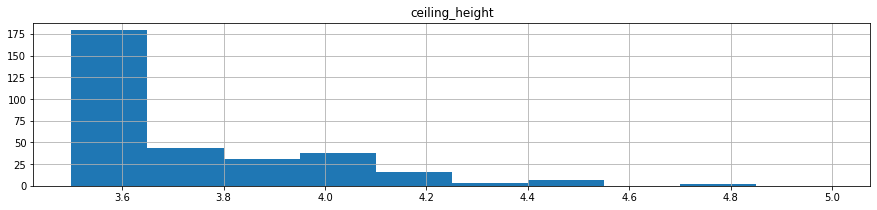

In [16]:
# check
data.hist(column = 'ceiling_height', bins = 10, figsize = (15,3), range = (3.5,5));

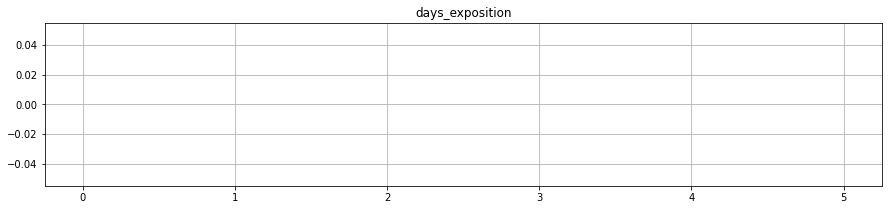

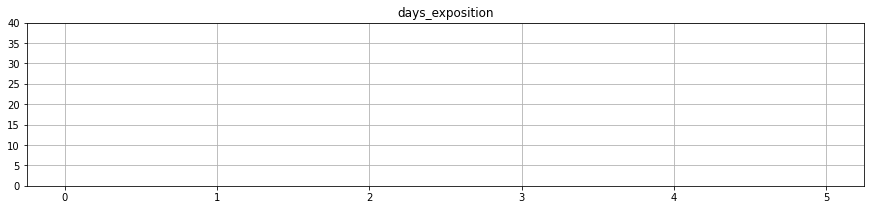

In [17]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [18]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [19]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


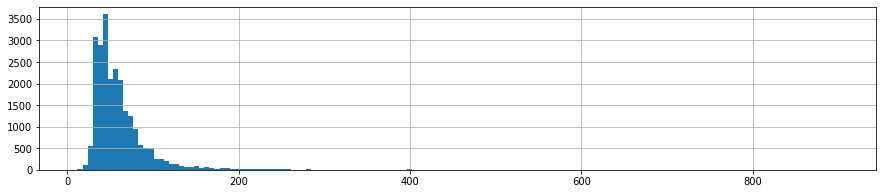

In [20]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

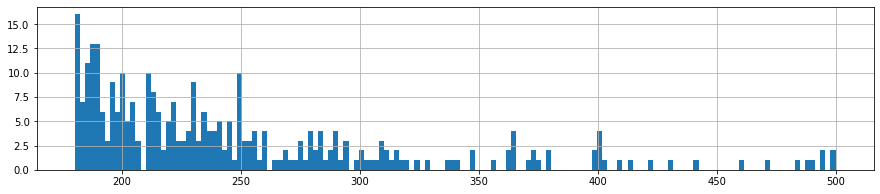

In [21]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

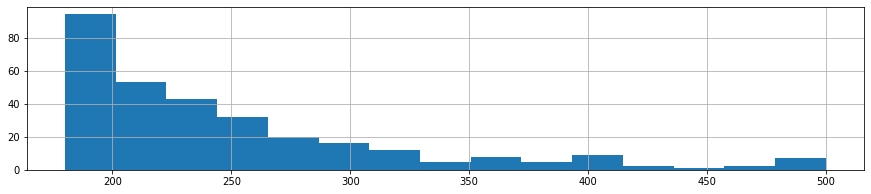

In [22]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

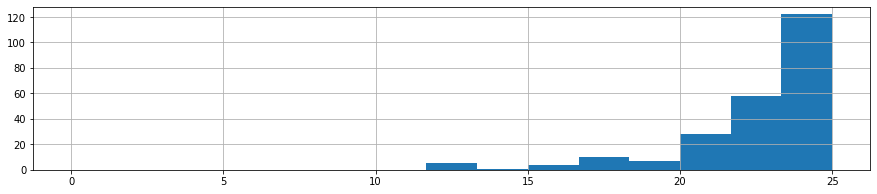

In [23]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [24]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.50,2.40,10.00,"600,000.00",10.00,5.00,1.00,2.00
0.01,1.00,26.00,2.50,11.00,"1,003,600.00",13.26,5.00,1.00,2.00
0.5,2.00,52.00,2.65,104.00,"4,600,000.00",30.00,9.09,4.00,9.00
0.99,5.00,158.00,3.50,986.42,"25,874,680.00",96.00,31.00,22.00,26.00
0.9988,6.00,190.68,4.10,"1,164.74","43,000,000.00",125.41,45.00,26.00,27.00


### Посчитайте и добавьте в таблицу новые столбцы

In [25]:
data['price'] = data['last_price'] / data['total_area']
data['price'] = data['price'].astype('int')
data = data[(data ['price'] <= 500000) | (data ['price'].isna()) ]

data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False,...,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370
1,7,3350000,40.40,2018-12-04,1,2.75,11,18.6,1,False,...,2,шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920
2,10,5196000,56.00,2015-08-20,2,2.55,5,34.3,4,False,...,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False,...,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.4,5,False,...,0,городской янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False,...,0,санкт-петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,72490
23695,14,3100000,59.00,2018-01-15,3,2.55,5,38.0,4,False,...,0,тосно,NaN,NaN,0,NaN,0,NaN,45.0,52542
23696,18,2500000,56.70,2018-02-11,2,2.80,3,29.7,1,False,...,0,рождествено,NaN,NaN,0,NaN,0,NaN,NaN,44091
23697,13,11475000,76.75,2017-03-28,2,3.00,17,NaN,12,False,...,2,санкт-петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,149511


In [26]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [27]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'

In [28]:
data['floor_category'] = data.apply(floor_category, axis = 1)
data['center_km'] = data['cityCenters_nearest'] / 1000
data['center_km'] = data['center_km'].fillna(value=0).astype(int)


Доавляем столбец с типом этажа - для людей имеет разница, только последний это этаж или первый, поэтому и оставляем только три типа. Так же меняем километры на метры в раастоянии до центра города, добавляем столбец с ценой за квадратный метр и меняем тип данных.

In [29]:
display(data.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price,weekday,month,year,floor_category,center_km
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,482.0,2,755.0,NaN,120370,3,3,2019,другой,16
1,7,3350000,40.40,2018-12-04,1,2.75,11,18.60,1,False,...,NaN,0,NaN,81.0,82920,1,12,2018,первый,18
2,10,5196000,56.00,2015-08-20,2,2.55,5,34.30,4,False,...,90.0,2,574.0,558.0,92785,3,8,2015,другой,13
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.0,1,48.0,121.0,100000,1,6,2018,другой,8
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,NaN,0,NaN,55.0,95065,0,9,2018,другой,0
6,6,3700000,37.30,2017-11-02,1,2.66,26,10.60,6,False,...,NaN,0,NaN,155.0,99195,3,11,2017,другой,19
7,5,7915000,71.60,2019-04-18,2,2.75,24,NaN,22,False,...,NaN,0,NaN,NaN,110544,3,4,2019,другой,11
8,20,2900000,33.16,2018-05-23,1,2.70,27,15.43,26,False,...,NaN,0,NaN,189.0,87454,2,5,2018,другой,0
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,NaN,0,NaN,289.0,88524,6,2,2017,другой,15
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.30,3,False,...,310.0,2,553.0,137.0,127525,3,11,2017,другой,13


### Проведите исследовательский анализ данных

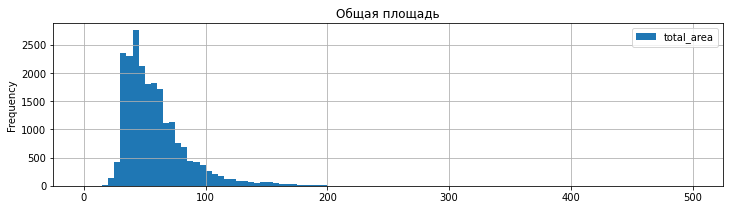

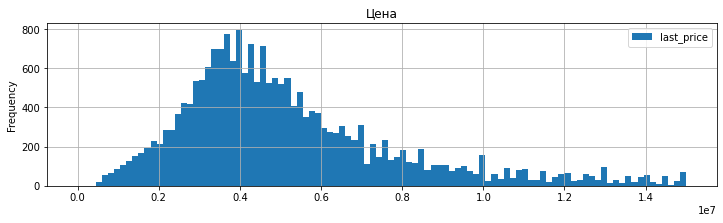

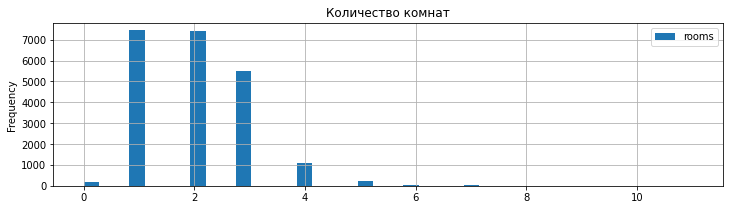

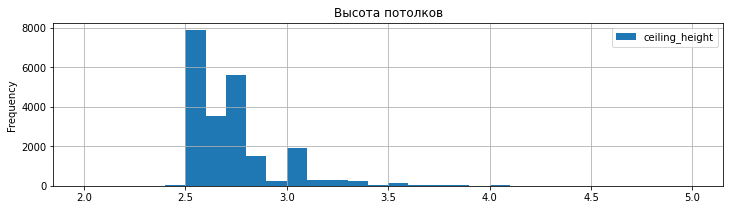

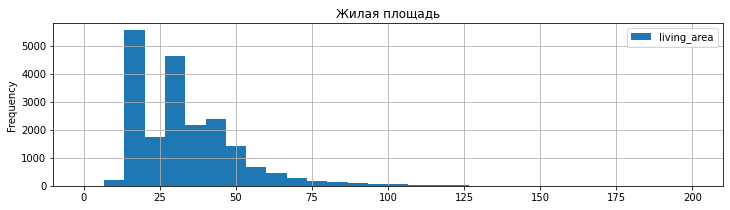

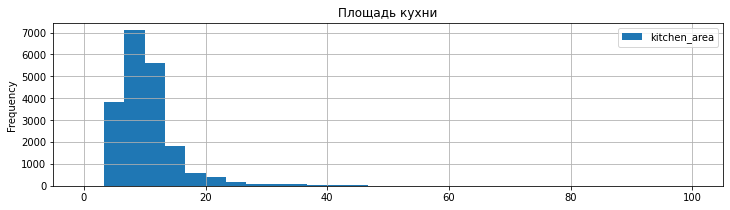

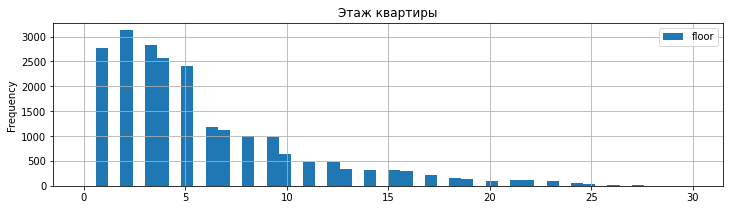

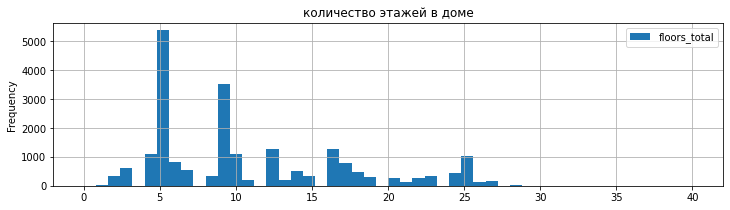

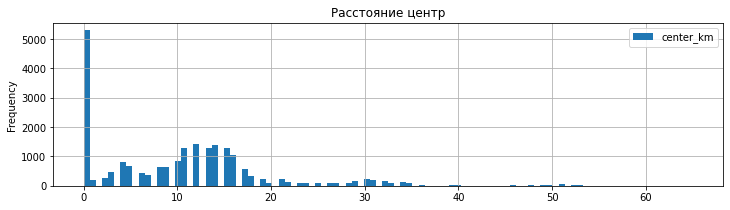

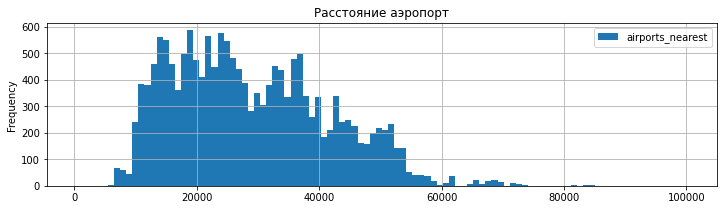

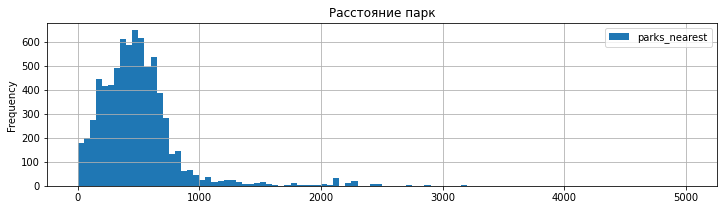

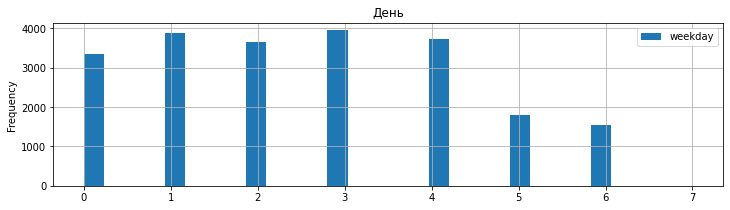

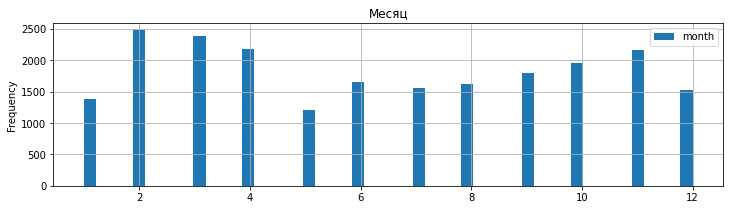

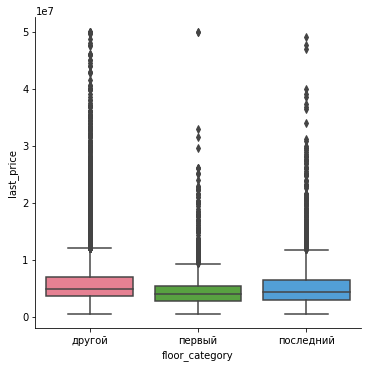

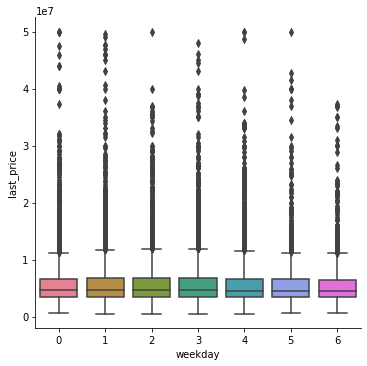

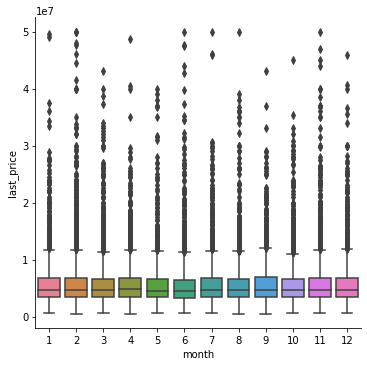

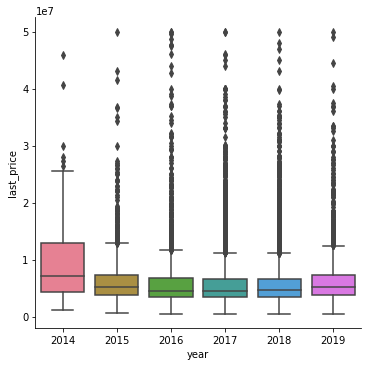

In [30]:
data.plot(title='Общая площадь', y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (12,3), range = (0,500))
data.plot(title='Цена', y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (12,3))
data.plot(title='Количество комнат', y = 'rooms', kind = 'hist', bins = 40, grid=True, figsize = (12,3))
data.plot(title='Высота потолков', y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (12,3))

data.plot(title='Жилая площадь', y = 'living_area', kind = 'hist', bins = 30, range = (0, 200), grid=True, figsize = (12,3))
data.plot(title='Площадь кухни', y = 'kitchen_area', kind = 'hist', bins = 30, range = (0, 100), grid=True, figsize = (12,3))
data.plot(title='Этаж квартиры', y = 'floor', kind = 'hist', bins = 50, range = (0, 30), grid=True, figsize = (12,3))
data.plot(title='количество этажей в доме', y = 'floors_total', kind = 'hist', bins = 50, range = (0, 40), grid=True, figsize = (12,3))

data.plot(title='Расстояние центр', y = 'center_km', kind = 'hist', bins = 100, grid=True, figsize = (12,3))
data.plot(title='Расстояние аэропорт', y = 'airports_nearest', kind = 'hist', bins = 100, range = (500, 100000), grid=True, figsize = (12,3))
data.plot(title='Расстояние парк', y = 'parks_nearest', kind = 'hist', bins = 100, range = (0, 5000), grid=True, figsize = (12,3))
data.plot(title='День', y = 'weekday', kind = 'hist', bins = 30, range = (0,7), grid=True, figsize = (12,3))
data.plot(title='Месяц', y = 'month', kind = 'hist', bins = 50, range = (1,12), grid=True, figsize = (12,3))


for column in ['floor_category', 'weekday', 'month', 'year']:
    sns.catplot(x=column, y="last_price", kind="box", data=data, palette='husl')




In [31]:
data['airports_nearest'].describe()
data['center_km'].describe()

count    21928.000000
mean        10.520887
std          9.550815
min          0.000000
25%          1.000000
50%         11.000000
75%         15.000000
max         65.000000
Name: center_km, dtype: float64

Как можно заметить, в основном продают 1-2 - комнатные квартиры, больше 4 вообще редкость, а больше 5, например 7-комнатные, вообще вызывают подозрения (хотя в петербурге это может быть и коммунальная квартира)

Большинство квартир до 100 кв. метров, с высотой потолков 2.5 - 3 метра.

Жилая площадь в основном до 50 квадратов, кухня в среднем 10 метров (от 5 до 15 встречается чаще всего). Большая часть квартир на 1-6 этажах, но много так же до 10 этажей включительно

Если парк рядом, то расстояние до него до 1 км, в среднем ~500 метров (неудивительно, в Ленобласти сплошные парки)

Начиная с пятницы объявлений все меньше, начинаются выходные. А по месясам проседает летом и зимой, больше всего объявлений в первые месяцы весны и осени.

До центра в среднем 10 км, а до аэропорта 30, исключили так же совсем мелкие значения, меньше км до аропорта - довольно странно

count    18855.000000
mean       184.507080
std        206.942316
min         10.000000
25%         45.000000
50%        104.000000
75%        239.500000
max       1200.000000
Name: days_exposition, dtype: float64


<AxesSubplot:>

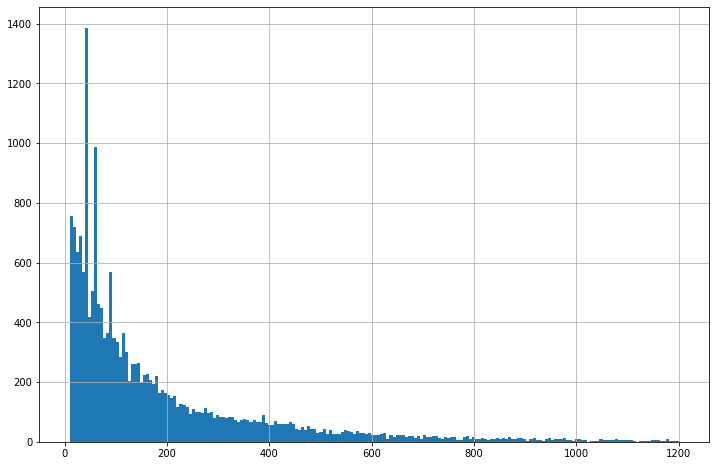

In [32]:
print(data['days_exposition'].describe())

data['days_exposition'].hist(bins=200, figsize=(12,8))

Медианное время продажи - 104 дня, среднее 184 день. Есть квартиры, которые продали в первые несколько дней после публикации объявления, но есть и те, что продавались месяцами.

Получается, что быстрыми продажами можно считать менее 45 дней, а долгими - больше 232

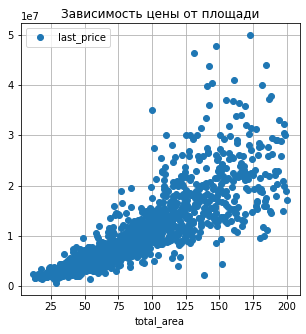

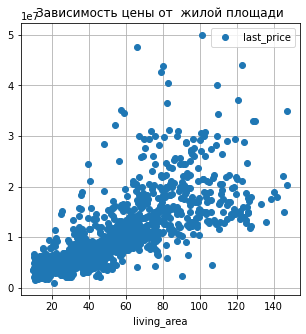

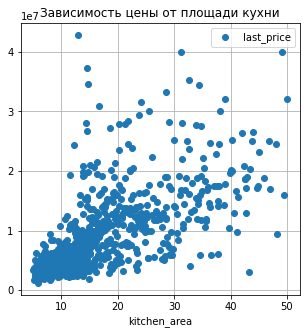

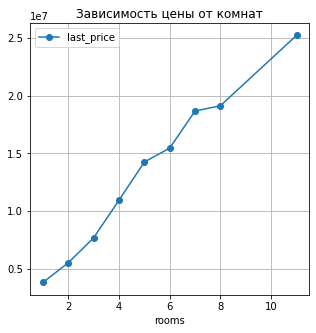

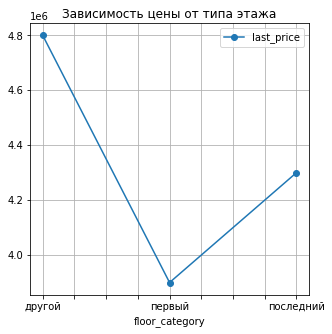

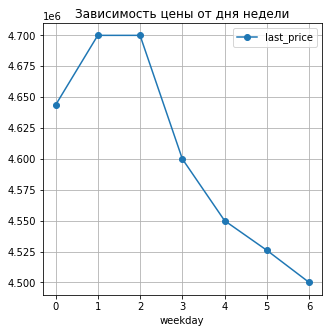

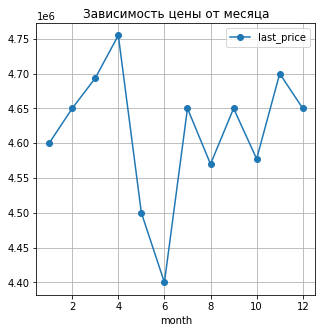

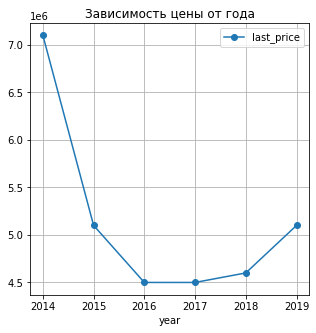

In [33]:
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(title='Зависимость цены от площади', grid=True, style='o', figsize=(5, 5))
)
plt.show()

(
    data.pivot_table(index='living_area', values='last_price')
    .plot(title='Зависимость цены от  жилой площади', grid=True, style='o', figsize=(5, 5))
)
plt.show()

(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(title='Зависимость цены от площади кухни', grid=True, style='o', figsize=(5, 5))
)
plt.show()

(
    data.query('rooms > 0').pivot_table(index='rooms', values='last_price')
    .plot(title='Зависимость цены от комнат', grid=True, style='o-', figsize=(5, 5))
)
plt.show()
(
    data.pivot_table(index='floor_category', values='last_price', aggfunc='median')
    .plot(title='Зависимость цены от типа этажа', grid=True, style='o-', figsize=(5, 5))
)
plt.show()

(
    data.pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(title='Зависимость цены от дня недели', grid=True, style='o-', figsize=(5, 5))
)
plt.show()

(
    data.pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(title='Зависимость цены от месяца', grid=True, style='o-', figsize=(5, 5))
)
plt.show()
(
    data.pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(title='Зависимость цены от года', grid=True, style='o-', figsize=(5, 5))
)
plt.show()

Графики говорят, что чем больше площадь, тем выше стоимость, чуть меньше зависимость от конкретно жилой площади, и почти не влияет площадь кухни. 

Зависимость между количеством комнат и стоимостью есть, но не сильная, комнат может быть много и при небольшой общей площади.
Самые дешевые квартиры на первом этаже, чуть дороже на последнем, "самый сок" оказался посередине.

Самые дорогие объявления дают в апреле, а вот самые дешевые в июне (это еще и при том, что летом вообще объявлений меньше)
С 2014 цена начала резко падать, достигла "пика" в 2017, а с 2019 опять рост.


<AxesSubplot:title={'center':'Изменение средней цены за метр по годам'}, xlabel='year'>

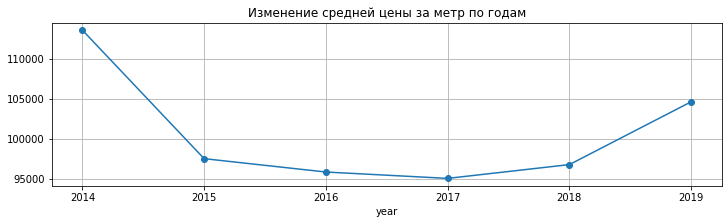

In [34]:
med_year = data.groupby('year')['price'].mean()
med_year.plot(title='Изменение средней цены за метр по годам', x = 'year', y = 'price', style='o-', grid=True, figsize = (12,3))


<AxesSubplot:title={'center':'Изменение средней площади по годам'}, xlabel='year'>

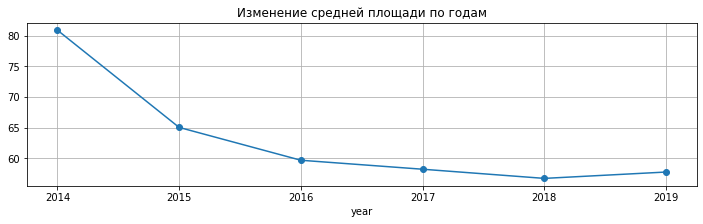

In [35]:
med_year_squere = data.groupby('year')['total_area'].mean()
med_year_squere.plot(title='Изменение средней площади по годам', x = 'year', y = 'total_area', style='o-', grid=True, figsize = (12,3))


Можно заметить, что графики очень похожи, то есть в целом уменьшалась и площадь и цена за кадратный метр, в глаза бросается исключение  20Можно заметить, что средняя площадь с годами уменьшалась (это есть и сейчас - большое количество крохотных студий), а цена за метр росла. В целом это взаимозависимые факторы, чтобы цена квартиры оставалась в рамках платежеспособности населения, площадь, от которой цена и завсит, снижается. Простой пример упаковка молока - милилитров все меньше, а цена на уровне19 - средняя цена за метр выросла сильнее, чем средняя площадь.

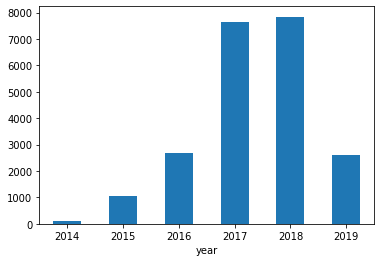

In [36]:
# check
data.groupby('year')['price'].count().plot.bar(rot = 0);

In [37]:
city_max = data['locality_name'].value_counts().head(10)
city_price = data.query('locality_name in (@city_max.index)').pivot_table(values='price', index='locality_name')
city_price = city_price.astype(int)
city_price.sort_values('price', ascending=False)


,price
locality_name,
санкт-петербург,111865
пушкин,102648
кудрово,95230
парголово,89921
мурино,86094
шушары,78654
колпино,75196
гатчина,68673
всеволожск,67377


<AxesSubplot:ylabel='locality_name'>

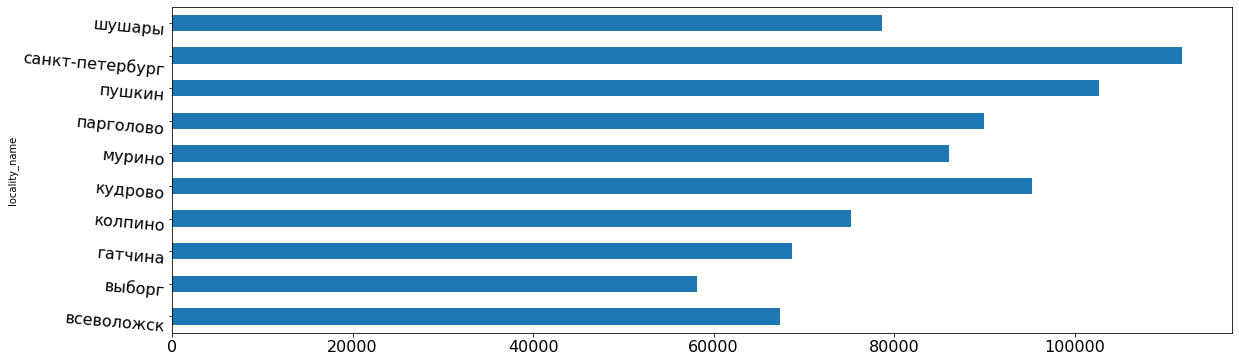

In [38]:
city_price.plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)


Самая высокая цена за метр в Петербурге, затем чуть ниже в Пушкине, Кудрово и Парголово - это все пригород Спб, хотя Пушкин достаточно далеко. Из топ-10 дешевле всего недвижимость в Выборге.

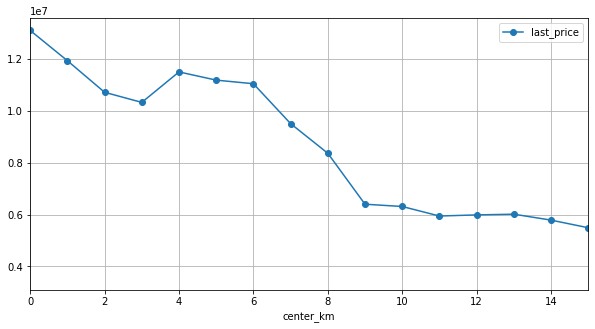

In [39]:
(
    data.query('locality_name == "санкт-петербург"')
    .pivot_table(index='center_km', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,15), figsize=(10, 5))
)
plt.show()

Чем дальше от центра, тем дешевле квадратный метр, но на расстоянии 3 км стоимость упала, вероятно это не самое комфортное расстояние до толп туристов


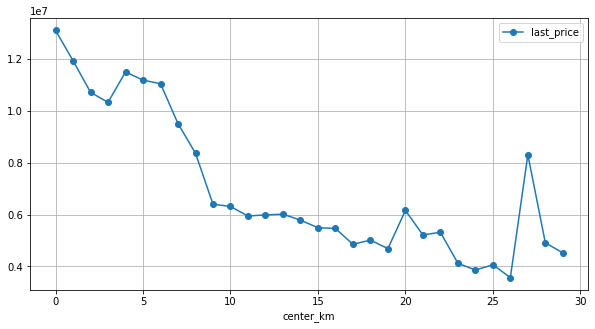

In [40]:
(
    data.query('locality_name == "санкт-петербург"')
    .pivot_table(index='center_km', values='last_price')
    .plot(grid=True, style='o-', figsize=(10, 5))
)
plt.show()

In [41]:
print(data.loc[((data['locality_name'] == "санкт-петербург") & (data['center_km'] == 27))])
print(len(data.loc[((data['floor_category'] == "первый") & (data['center_km'] == 3))]))
print(len(data.loc[((data['floor_category'] == "последний") & (data['center_km'] == 3))]))
print(len(data.loc[((data['floor_category'] == "другой") & (data['center_km'] == 3))]))
print(len(data.loc[((data['floor_category'] == "первый") & (data['center_km'] == 5))]))
print(len(data.loc[((data['floor_category'] == "последний") & (data['center_km'] == 5))]))
print(len(data.loc[((data['floor_category'] == "другой") & (data['center_km'] == 5))]))

      total_images  last_price  total_area first_day_exposition  rooms  \
748             13    14350000        74.0           2017-11-28      2   
5961             6     2250000        32.0           2018-02-27      1   

      ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
748             3.13             5         30.0      3         False  ...   
5961            2.70             2         16.5      2         False  ...   

      parks_nearest  ponds_around3000  ponds_nearest  days_exposition   price  \
748          1496.0                 0            NaN            128.0  193918   
5961            NaN                 0            NaN            178.0   70312   

      weekday  month  year  floor_category  center_km  
748         1     11  2017          другой         27  
5961        1      2  2018       последний         27  

[2 rows x 28 columns]
70
100
309
68
98
502


На 27 км от центра есть всего две квартиры, одна из которых в 74 квадрата стоимостью больше 14 млн, она и дала такой пик на графике. 2 комнаты, высокие потолки, рядом парк и почти 200 тыс за квадратный метр

### Общий вывод

В ходе исследования мы проанализировали представленные данные, удалили дубликаты и аномально большие и маленькие нелогичные значения, а так же те, что выходят за рамки исследования. В целом можно заметить довольно логичные закономерности - стоимость квартиры зависит от площади, причем от площади зависимость сильнее, чем от количества комнат, типа этажа и удаленности от центра города, как и от центра района. Присутствует и сезонность - летом и зимой объявлений меньше, кому хочется продавать квартиру находясь в отпуске или в суматохе праздников?

Посмотрев на графики можно заметить преобладание довольно средних потолков 2.5-3 метра с количеством комнат от 1 до 3, но есть квартиры и больше, при условии метража до 100 квадратов. 

В среднем квартиры продают за 104 дня, но бывает и дольше - несколько месяцев. Кому-то совсем везет - квартира продается аж за несколько дней после публикации.

Дороже всего квартиры в Петербруге и его пригороде, если смотреть чуть дальше, то дороже всего в Выборге.

Самые дорогие объявления были в 2014, потом резко упали, это связано с тем, что в 2014-15 годах Россия столкнулась с серьезным валютно-финансовым кризисом, грозящим перерасти в глубокий экономический кризис, но ситуация начала выправляться, а значит и стоимость квартир - понемногу расти. При этом средняя площадь квартир уменьшалась, а средняя цена за метр росла.

Суммируя можно сказать, что самые дорогие квартиры - те, что находятся не на первом\последнем этаже, с большой площадью и количеством комнат, в относительной близости к центру Санкт-Петербурга и ближайшему парку. Самые дешевые же, наоборот, если смотреть по Лен области, то далеко от СПб, рядом нет парков, этаж первый, а жилплощадь совсем небольшая.